<a href="https://colab.research.google.com/github/dongddaoist/APPRET/blob/main/dataset_split_ecfp_umap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torch-geometric

# Install rdkit (should only be installed via conda)

!pip install --quiet rdkit-pypi > /dev/null
!pip install optuna

# Inshttps://drive.google.com/drive/search?q=owner%3Ame%20(type%3Aapplication%2Fvnd.google.colaboratory%20%7C%7C%20type%3Aapplication%2Fvnd.google.colab)&authuser=0tall UMAP/hdbscan (recommend to do this before miniconda)
!pip install --quiet umap-learn hdbscan

!pip install pandas numpy scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

In [2]:
# import dataset, necessary to run for any reconection
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive/')
ifile= '/content/drive/My Drive/machine-learning/Data/bradley/BradleyDataset_no_duplicates.csv'
# Load your CSV file
df = pd.read_csv(ifile)


Mounted at /content/drive/


In [7]:
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

def smiles_to_ecfp(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    else:
        return None



In [ ]:
df['ecfp'] = df['SMILES'].apply(smiles_to_ecfp)
df = df.dropna(subset=['ecfp'])
ecfp_array = np.array(df['ecfp'].tolist())


In [8]:
from sklearn.cluster import KMeans
import numpy as np

# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
ecfp_array_scaled = scaler.fit_transform(ecfp_array)

# Cluster using KMeans
num_clusters = 10  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(ecfp_array_scaled)

df['cluster'] = clusters


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [11]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Balance the dataset by oversampling and undersampling
# Adjust sampling strategy based on your needs
sampling_strategy = {i: max(100, sum(clusters == i)) for i in range(num_clusters)}

# Under-sample the majority class and over-sample the minority class
undersample = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
oversample = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

# Create new balanced dataset
X_resampled, y_resampled = oversample.fit_resample(ecfp_array_scaled, clusters)
X_resampled, y_resampled = undersample.fit_resample(X_resampled, y_resampled)

# Update df_all with the resampled data
resampled_indices = np.where(np.isin(clusters, y_resampled))[0]
df_resampled = df.iloc[resampled_indices]


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


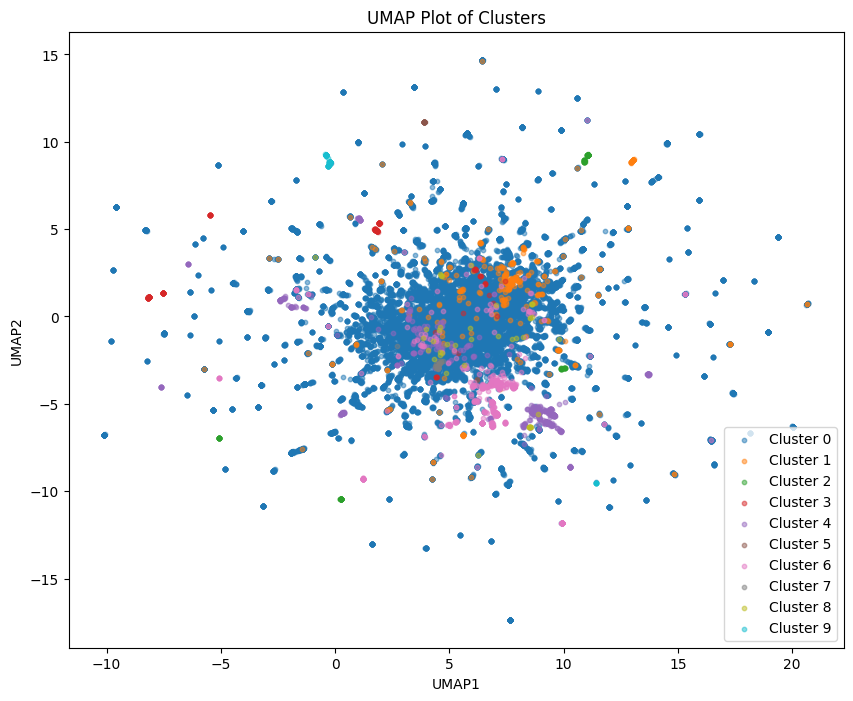

In [13]:
import umap
import matplotlib.pyplot as plt

# Apply UMAP for visualization
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_embedding = umap_reducer.fit_transform(ecfp_array_scaled)

# Add UMAP embeddings to the dataframe
df[['UMAP1', 'UMAP2']] = umap_embedding

# Visualize the balanced dataset
plt.figure(figsize=(10, 8))
for cluster in np.unique(df['cluster']):
    subset = df[df['cluster'] == cluster]
    plt.scatter(subset['UMAP1'], subset['UMAP2'], label=f'Cluster {cluster}', alpha=0.5, s=10)

plt.legend()
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Plot of Clusters')
plt.show()


In [14]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import umap
import matplotlib.pyplot as plt

# Assuming df is your original dataframe with 'isosmiles' column
df['label'] = 'original'

# Compute ECFP descriptors
def smiles_to_ecfp(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    else:
        return None

df['ecfp'] = df['SMILES'].apply(smiles_to_ecfp)
df = df.dropna(subset=['ecfp'])
ecfp_array = np.array(df['ecfp'].tolist())

# Standardize the data
scaler = StandardScaler()
ecfp_array_scaled = scaler.fit_transform(ecfp_array)

# Cluster using KMeans
num_clusters = 10  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(ecfp_array_scaled)

df['cluster'] = clusters

# Balance the dataset by oversampling and undersampling
sampling_strategy = {i: max(100, sum(clusters == i)) for i in range(num_clusters)}

oversample = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = oversample.fit_resample(ecfp_array_scaled, clusters)

# Create new dataframe for resampled data
df_resampled = pd.DataFrame(X_resampled, columns=[f'ECFP_{i}' for i in range(X_resampled.shape[1])])
df_resampled['cluster'] = y_resampled
df_resampled['label'] = 'selected'

# Combine the original and selected datasets
combined_df = pd.concat([df, df_resampled], ignore_index=True)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Apply UMAP
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_embedding = umap_reducer.fit_transform(np.vstack((ecfp_array_scaled, X_resampled)))

combined_df[['UMAP1', 'UMAP2']] = umap_embedding




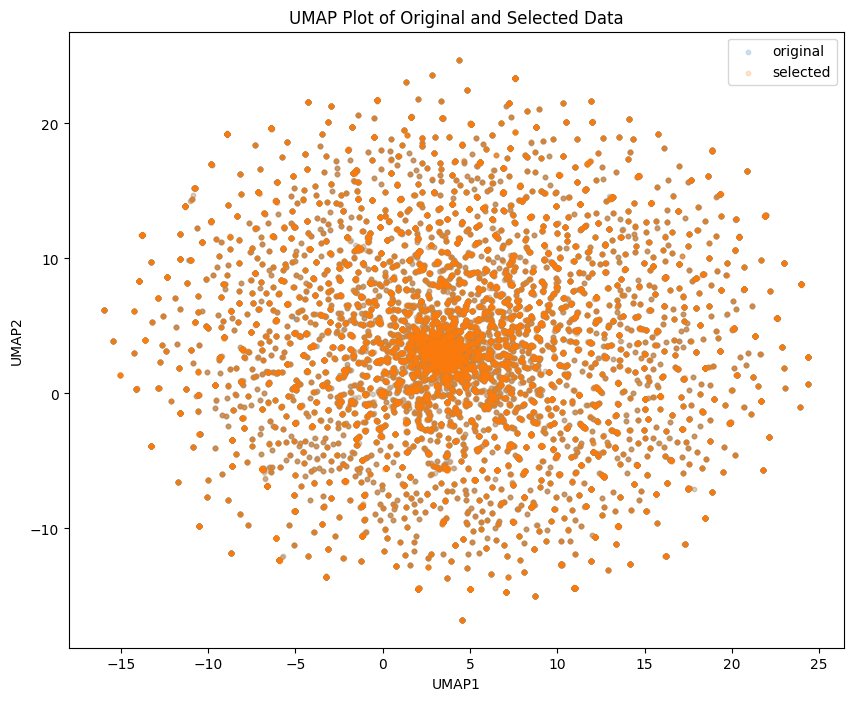

In [16]:
# Visualize the UMAP plot
plt.figure(figsize=(10, 8))
for label in combined_df['label'].unique():
    subset = combined_df[combined_df['label'] == label]
    plt.scatter(subset['UMAP1'], subset['UMAP2'], label=label, alpha=0.2, s=10)

plt.legend()
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Plot of Original and Selected Data')
plt.show()

The folklowing is the moethod which splict the original dataset into 2 and color them separately.

In [3]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.preprocessing import StandardScaler
import umap

# Assuming df is your DataFrame with a 'SMILES' column
def smiles_to_ecfp(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    else:
        return None

df['ecfp'] = df['SMILES'].apply(smiles_to_ecfp)
df = df.dropna(subset=['ecfp'])
ecfp_array = np.array(df['ecfp'].tolist())

# Standardize the data
scaler = StandardScaler()
ecfp_array_scaled = scaler.fit_transform(ecfp_array)

# Apply UMAP
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_embedding = umap_reducer.fit_transform(ecfp_array_scaled)

# Add UMAP embeddings to a new DataFrame
umap_df = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2'])
umap_df['index'] = df.index


[13:44:58] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 12 13 15 16 17 18 19 22 23 24
[13:44:58] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 7 8 10 11 12 13 15 16 17 19
[13:44:58] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 11 12 13 15 16 17 18
[13:44:58] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 12 13 15 16 17 18 19 21 22 23
[13:44:58] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 12 13 15 16 17 18 19 20 21 22
[13:44:59] Explicit valence for atom # 20 C, 5, is greater than permitted
[13:44:59] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[13:44:59] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 23
[13:44:59] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[13:44:59] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[13:44:59] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[13:44:59] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[13:44:59] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 

In [40]:
from sklearn.model_selection import train_test_split

# Split the dataset indices
train_indices, test_indices = train_test_split(df.index, test_size=0.2, random_state=42)

# Map the indices to UMAP embeddings
umap_df['set'] = 'test'
umap_df.loc[umap_df['index'].isin(train_indices), 'set'] = 'train'


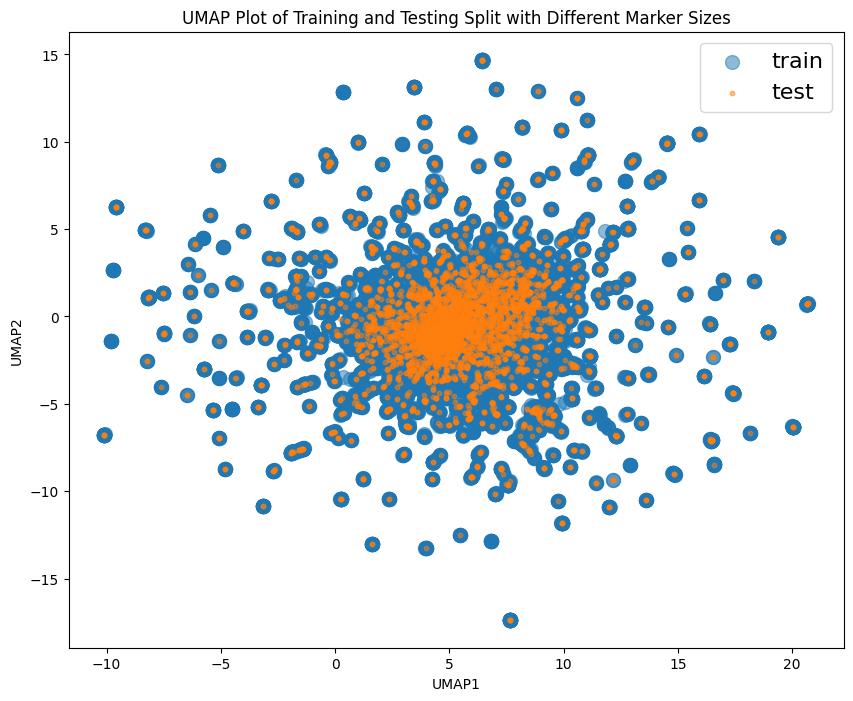

In [44]:
import matplotlib.pyplot as plt

# Plot UMAP with different marker sizes
plt.figure(figsize=(10, 8))
for data_set in umap_df['set'].unique():
    subset = umap_df[umap_df['set'] == data_set]
    marker_size = 100 if data_set == 'train' else 10  # Larger size for training, smaller size for testing
    plt.scatter(subset['UMAP1'], subset['UMAP2'], label=data_set, alpha=0.5, s=marker_size)

plt.legend(fontsize=16)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Plot of Training and Testing Split with Different Marker Sizes')
plt.show()


This following revisions will add molecular weight and color the dots based on it.

In [16]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame with a 'SMILES' column

# Function to compute ECFP descriptors
def smiles_to_ecfp(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    else:
        return None

# Function to compute molecular weight
def compute_molecular_weight(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return Descriptors.MolWt(mol)
    else:
        return None

# Compute ECFP descriptors and molecular weight
df['ecfp'] = df['SMILES'].apply(smiles_to_ecfp)
df['molecular_weight'] = df['SMILES'].apply(compute_molecular_weight)
df = df.dropna(subset=['ecfp', 'molecular_weight'])

# Convert ECFP descriptors to numpy array
ecfp_array = np.array(df['ecfp'].tolist())

# Standardize the data
scaler = StandardScaler()
ecfp_array_scaled = scaler.fit_transform(ecfp_array)

# Apply UMAP
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_embedding = umap_reducer.fit_transform(ecfp_array_scaled)

# Add UMAP embeddings to a new DataFrame
umap_df = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2'])
umap_df['index'] = df.index
umap_df['molecular_weight'] = df['molecular_weight'].values


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [17]:
# Split the dataset indices
train_indices, test_indices = train_test_split(df.index, test_size=0.2, random_state=42)

# Map the indices to UMAP embeddings
umap_df['set'] = 'test'
umap_df.loc[umap_df['index'].isin(train_indices), 'set'] = 'train'


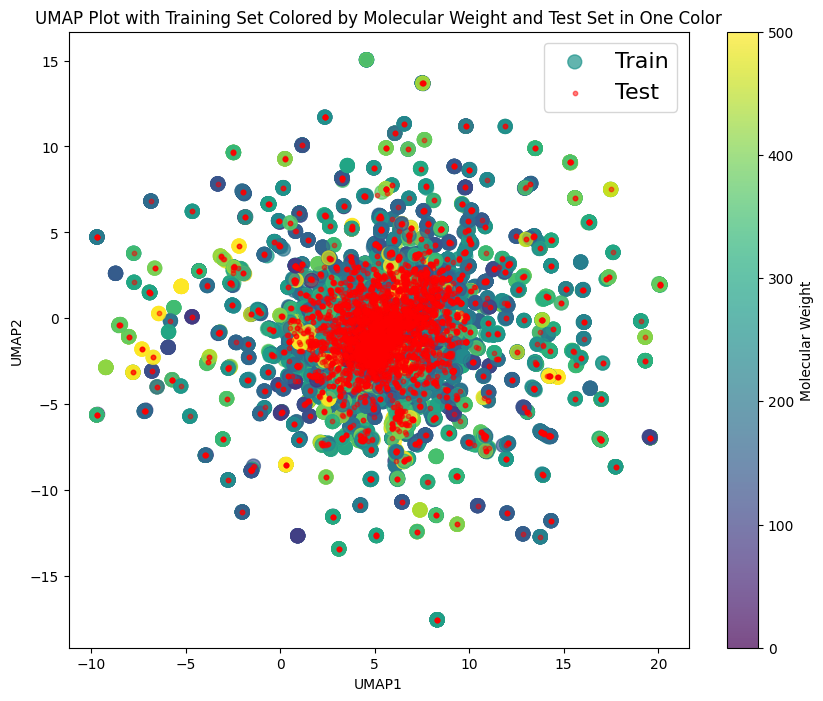

In [22]:
import matplotlib.pyplot as plt

# Plot UMAP with coloring by molecular weight for training set and one color for testing set
plt.figure(figsize=(10, 8))

# Normalize the molecular weight for color mapping

norm = plt.Normalize(0, 500)

cmap = plt.get_cmap('viridis')

# Plot all data points with molecular weight color for training set
train_subset = umap_df[umap_df['set'] == 'train']
sc = plt.scatter(train_subset['UMAP1'], train_subset['UMAP2'], c=train_subset['molecular_weight'], cmap=cmap, alpha=0.7, s=100, norm=norm, label='Train')

# Plot test set with a single color
test_subset = umap_df[umap_df['set'] == 'test']
plt.scatter(test_subset['UMAP1'], test_subset['UMAP2'], color='red', alpha=0.5, s=10, label='Test')

plt.colorbar(sc, label='Molecular Weight')
plt.legend(fontsize=16)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Plot with Training Set Colored by Molecular Weight and Test Set in One Color')
plt.show()
